In [2]:
import torch
import numpy as np
from sklearn.datasets import fetch_olivetti_faces
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras.layers import Input, Conv2D, MaxPooling2D, Dropout, GlobalAveragePooling2D, Dense, Lambda
from keras.models import Model
from keras import backend as k

In [3]:
# Set device to GPU if available, otherwise CPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [4]:
# Load the Olivetti faces dataset
data = fetch_olivetti_faces()
images_dataset = data.images
labels_dataset = data.target

In [5]:
# Define the model creation function
def create_model():
    inputs = Input((64, 64, 1))
    x = Conv2D(96, (11, 11), padding="same", activation="relu")(inputs)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.3)(x)

    x = Conv2D(256, (5, 5), padding="same", activation="relu")(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.3)(x)

    x = Conv2D(384, (3, 3), padding="same", activation="relu")(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.3)(x)

    pooledOutput = GlobalAveragePooling2D()(x)
    pooledOutput = Dense(1024)(pooledOutput)
    outputs = Dense(128)(pooledOutput)

    model = Model(inputs, outputs)
    return model

In [6]:
# Create the feature extractor model
feature_extractor = create_model()

# Define the input layers for the two images
imgA = Input(shape=(64, 64, 1))
imgB = Input(shape=(64, 64, 1))

# Extract features from both images
featA = feature_extractor(imgA)
featB = feature_extractor(imgB)

In [7]:
import tensorflow as tf

In [8]:
# Define the Euclidean distance function
def euclidean_distance(vectors):
    (featA, featB) = vectors
    sum_squared = tf.reduce_sum(tf.square(featA - featB), axis=1, keepdims=True)
    return tf.sqrt(tf.maximum(sum_squared, k.epsilon()))

In [9]:
import keras
print(keras.__version__)

3.4.1


In [10]:
# Calculate the distance between the two feature vectors
distance = Lambda(euclidean_distance, output_shape=(1,))([featA, featB])

# Add a sigmoid layer to get a probability
outputs = Dense(1, activation="sigmoid")(distance)

# Create the Siamese model
model = Model(inputs=[imgA, imgB], outputs=outputs)

# Compile the model
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [11]:
# Function to generate image pairs for training/testing
def generate_image_pairs(images_dataset, labels_dataset):
    unique_labels = np.unique(labels_dataset)
    label_wise_indices = dict()
    for label in unique_labels:
        label_wise_indices.setdefault(label,
                                      [index for index, curr_label in enumerate(labels_dataset) if
                                       label == curr_label])
    
    pair_images = []
    pair_labels = []
    for index, image in enumerate(images_dataset):
        pos_indices = label_wise_indices.get(labels_dataset[index])
        pos_image = images_dataset[np.random.choice(pos_indices)]
        pair_images.append((image, pos_image))
        pair_labels.append(1)

        neg_indices = np.where(labels_dataset != labels_dataset[index])
        neg_image = images_dataset[np.random.choice(neg_indices[0])]
        pair_images.append((image, neg_image))
        pair_labels.append(0)
    return np.array(pair_images), np.array(pair_labels)

In [19]:
# Generate image pairs
images_pair, labels_pair = generate_image_pairs(images_dataset, labels_dataset)

# Split into training and testing sets
train_images, test_images, train_labels, test_labels = train_test_split(images_pair, labels_pair, test_size=0.2, random_state=42)

# Train the model
history = model.fit([train_images[:, 0], train_images[:, 1]], train_labels[:],
                    validation_split=0.1, batch_size=64, epochs=100)

# Evaluate the model on the test set
test_predictions = model.predict([test_images[:, 0], test_images[:, 1]])




Epoch 1/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 0.8090 - loss: 0.4668 - val_accuracy: 0.7812 - val_loss: 0.4954
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - accuracy: 0.7844 - loss: 0.4665 - val_accuracy: 0.7812 - val_loss: 0.4870
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 0.8021 - loss: 0.4688 - val_accuracy: 0.8438 - val_loss: 0.4693
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 0.7946 - loss: 0.4806 - val_accuracy: 0.7969 - val_loss: 0.4712
Epoch 5/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - accuracy: 0.8288 - loss: 0.4348 - val_accuracy: 0.8125 - val_loss: 0.4848
Epoch 6/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - accuracy: 0.8207 - loss: 0.4634 - val_accuracy: 0.7969 - val_loss: 0.4519
Epoch 7/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - accuracy: 0.7984 - loss: 0.4564 - val_accuracy: 0.7812 - val_loss: 0.4845
Epoch 8/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - accuracy: 0.8340 - loss: 0.4389 - val_accuracy: 0.7969 - val_loss: 0.4805


In [21]:
# Function to perform grid search for the best threshold
def grid_search_threshold(test_predictions, test_labels, thresholds):
    best_threshold = None
    best_accuracy = 0
    
    for threshold in thresholds:
        predictions = (test_predictions > threshold).astype(int)
        accuracy = np.mean(predictions == test_labels[:, None])
        print(f"Threshold: {threshold}, Accuracy: {accuracy * 100:.2f}%")
        
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_threshold = threshold
            
    return best_threshold, best_accuracy

# Define a range of thresholds to search over
thresholds = np.arange(0.1, 1.0, 0.05)

# Perform the grid search
best_threshold, best_accuracy = grid_search_threshold(test_predictions, test_labels, thresholds)
print(f"Best Threshold: {best_threshold}, Best Accuracy: {best_accuracy * 100:.2f}%")


Threshold: 0.1, Accuracy: 76.25%
Threshold: 0.15000000000000002, Accuracy: 79.38%
Threshold: 0.20000000000000004, Accuracy: 81.88%
Threshold: 0.25000000000000006, Accuracy: 84.38%
Threshold: 0.30000000000000004, Accuracy: 86.88%
Threshold: 0.3500000000000001, Accuracy: 88.75%
Threshold: 0.40000000000000013, Accuracy: 90.00%
Threshold: 0.45000000000000007, Accuracy: 88.12%
Threshold: 0.5000000000000001, Accuracy: 86.25%
Threshold: 0.5500000000000002, Accuracy: 86.25%
Threshold: 0.6000000000000002, Accuracy: 87.50%
Threshold: 0.6500000000000001, Accuracy: 84.38%
Threshold: 0.7000000000000002, Accuracy: 77.50%
Threshold: 0.7500000000000002, Accuracy: 65.00%
Threshold: 0.8000000000000002, Accuracy: 53.12%
Threshold: 0.8500000000000002, Accuracy: 44.38%
Threshold: 0.9000000000000002, Accuracy: 44.38%
Threshold: 0.9500000000000003, Accuracy: 44.38%
Best Threshold: 0.40000000000000013, Best Accuracy: 90.00%


In [23]:
# Use the best threshold to make final predictions
final_predictions = (test_predictions > best_threshold).astype(int)

In [25]:
print(final_predictions)


[[1]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [1]
 [1]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [0]
 [1]
 [0]
 [1]
 [0]
 [1]
 [0]
 [1]
 [1]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [1]
 [1]
 [0]
 [1]]


In [26]:
# Display test image pairs with predictions and actual labels
def show_images_and_predictions(pair, predicted_label, actual_label):
    plt.figure(figsize=(5, 2))

    # Display first image
    plt.subplot(1, 2, 1)
    plt.imshow(pair[0].reshape(64, 64), cmap='gray')
    plt.axis('off')

    # Display second image
    plt.subplot(1, 2, 2)
    plt.imshow(pair[1].reshape(64, 64), cmap='gray')
    plt.axis('off')

    # Print prediction and actual label
    plt.suptitle(f"Predicted: {predicted_label[0]}, Actual: {actual_label}")
    plt.show()

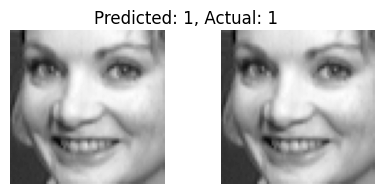

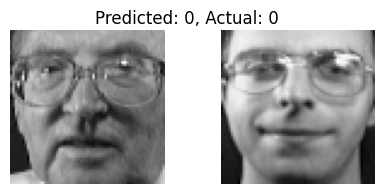

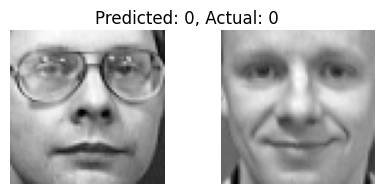

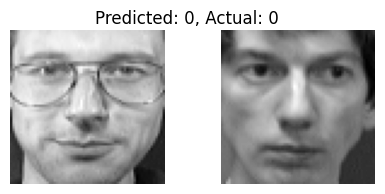

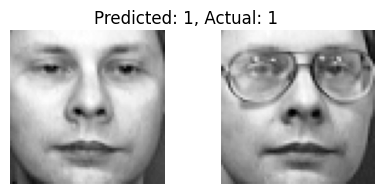

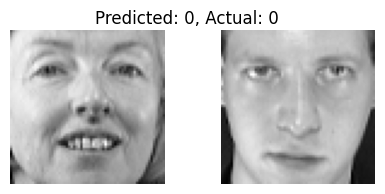

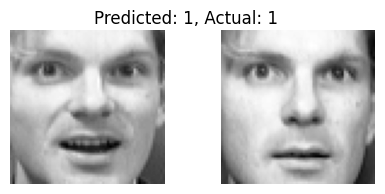

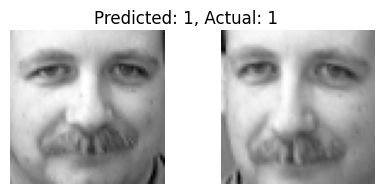

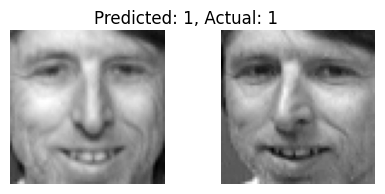

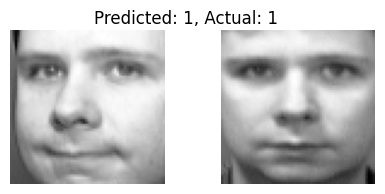

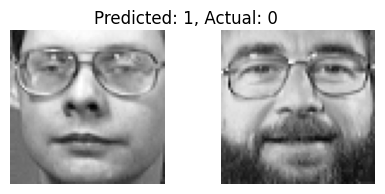

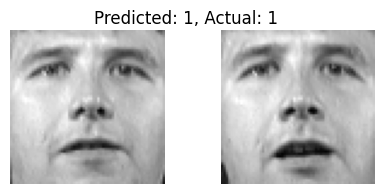

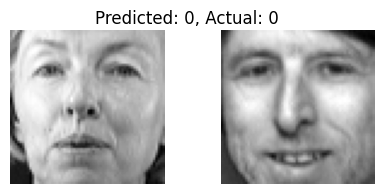

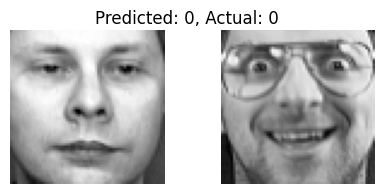

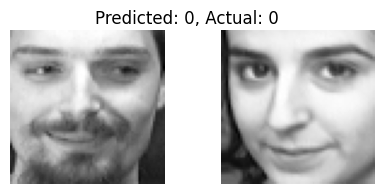

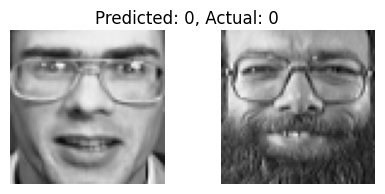

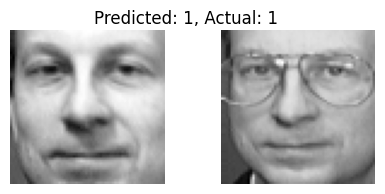

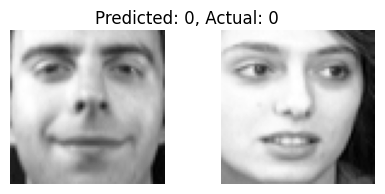

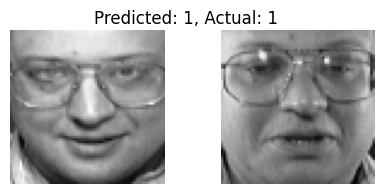

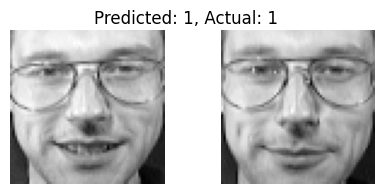

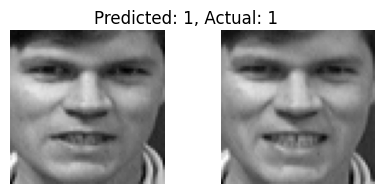

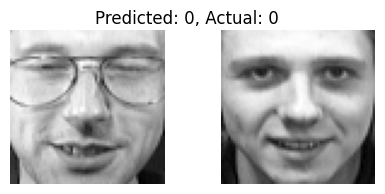

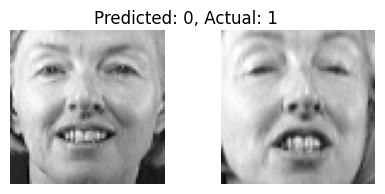

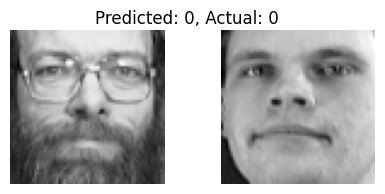

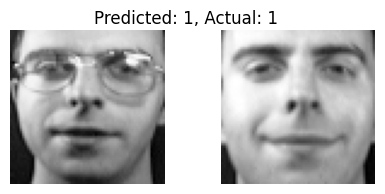

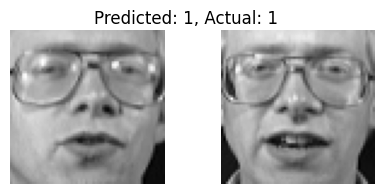

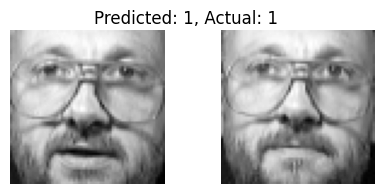

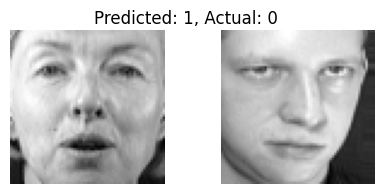

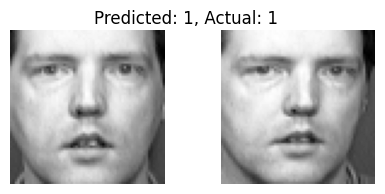

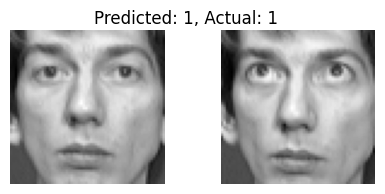

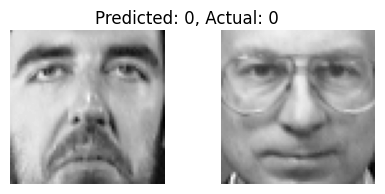

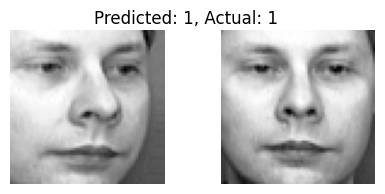

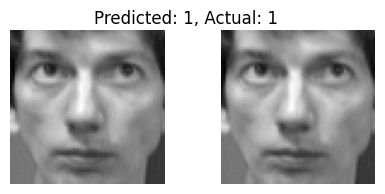

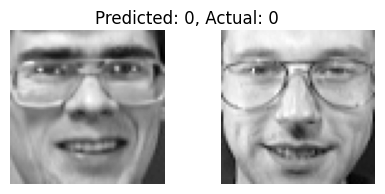

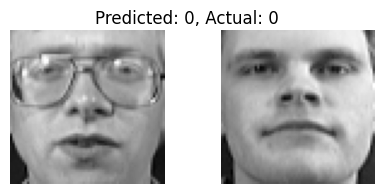

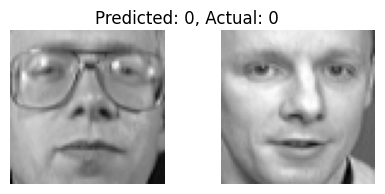

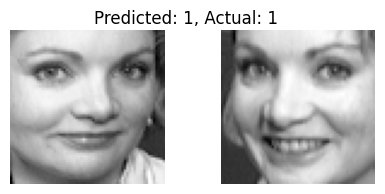

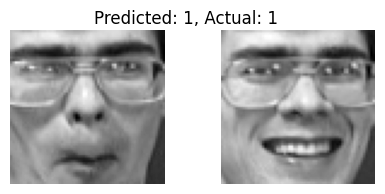

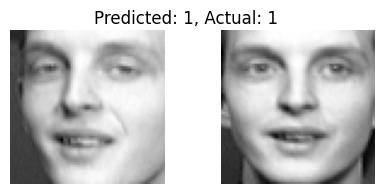

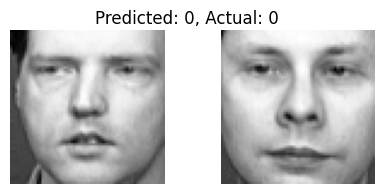

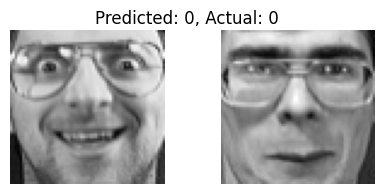

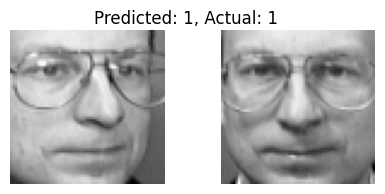

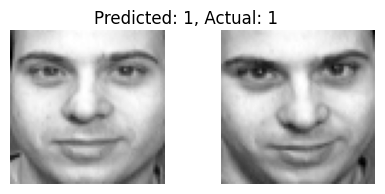

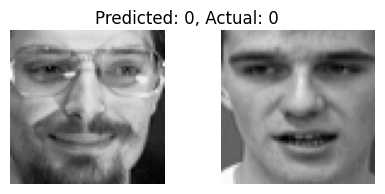

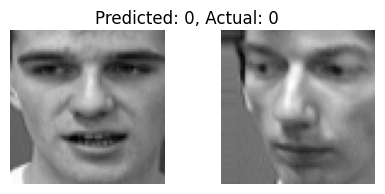

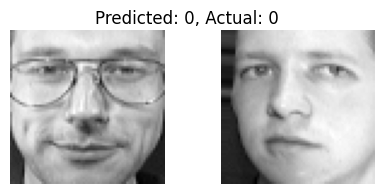

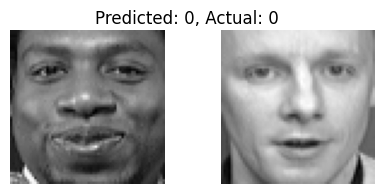

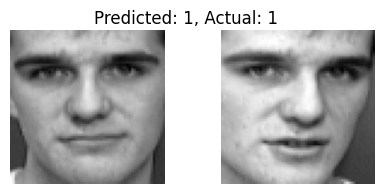

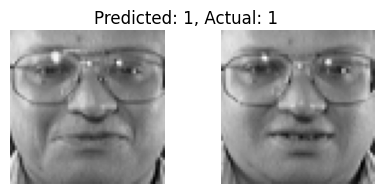

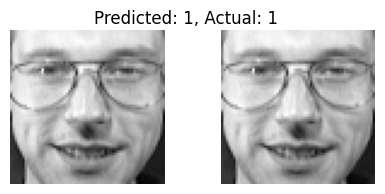

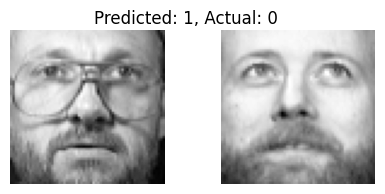

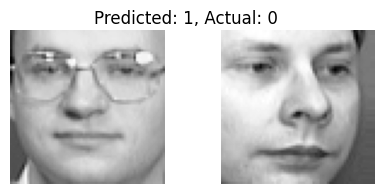

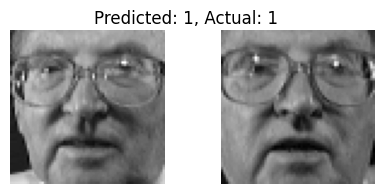

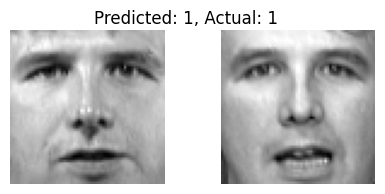

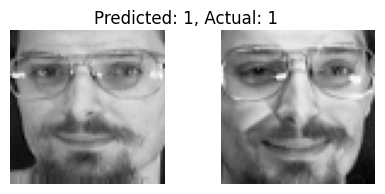

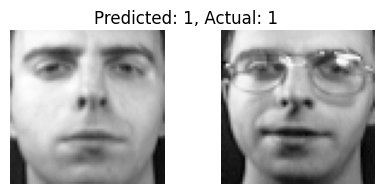

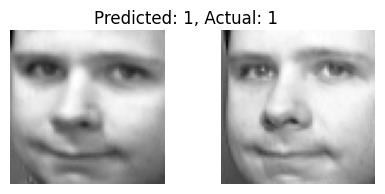

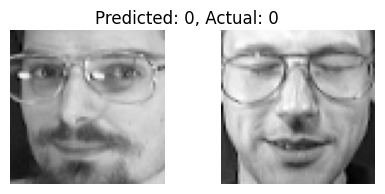

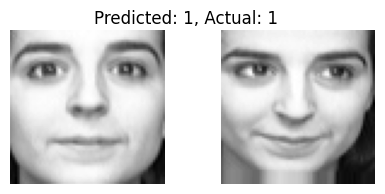

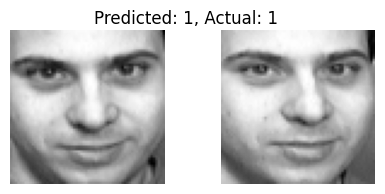

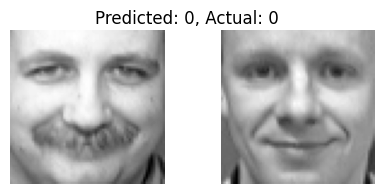

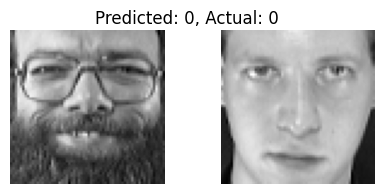

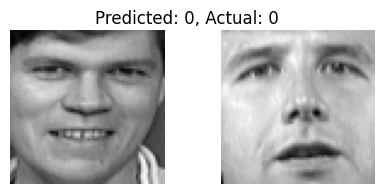

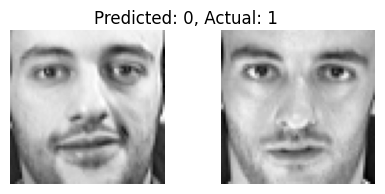

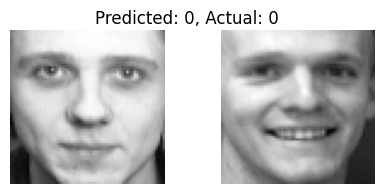

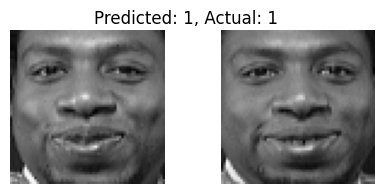

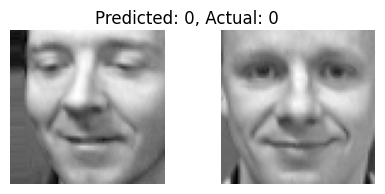

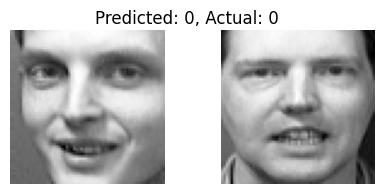

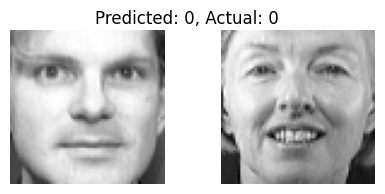

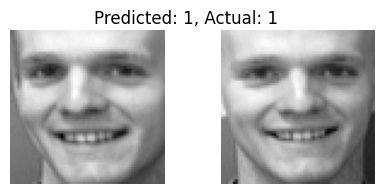

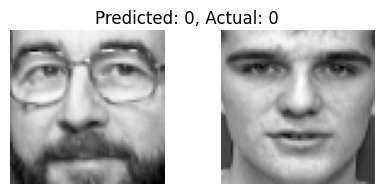

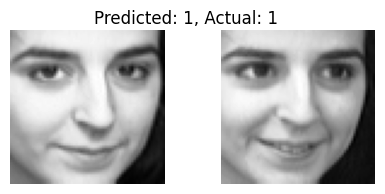

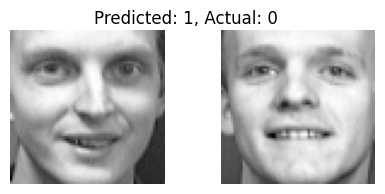

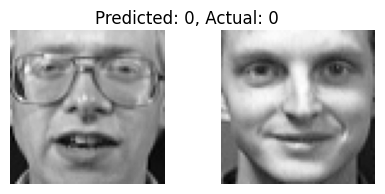

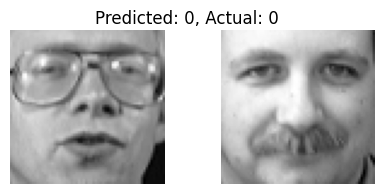

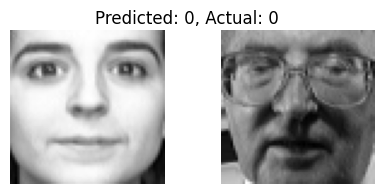

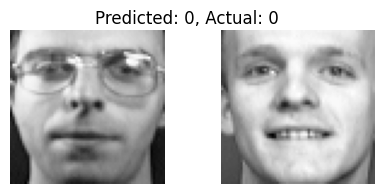

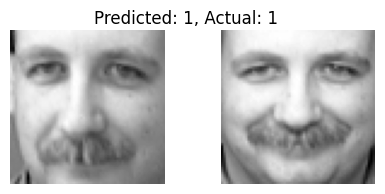

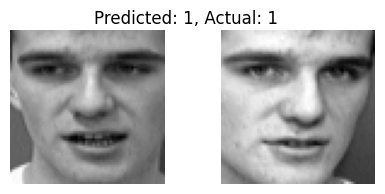

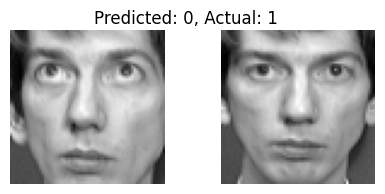

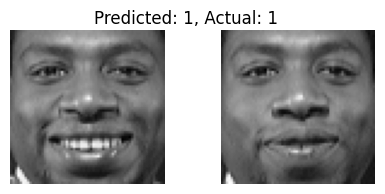

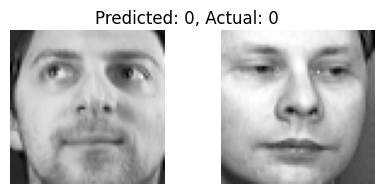

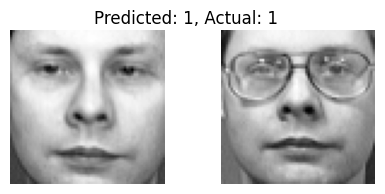

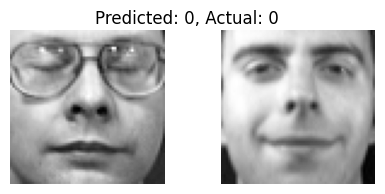

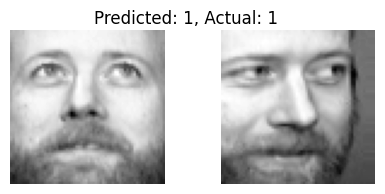

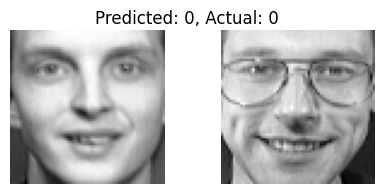

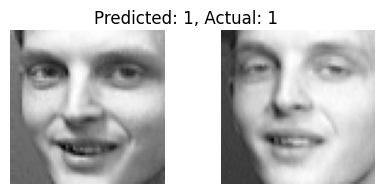

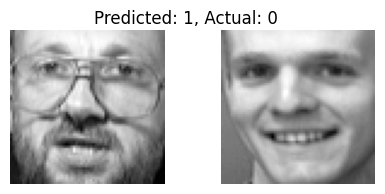

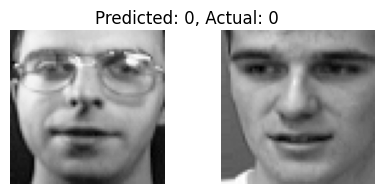

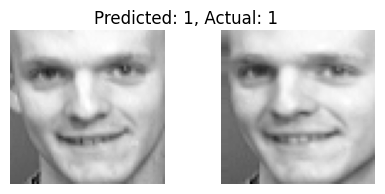

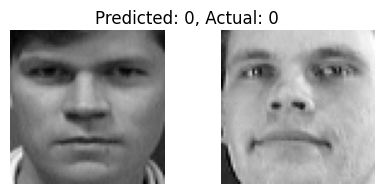

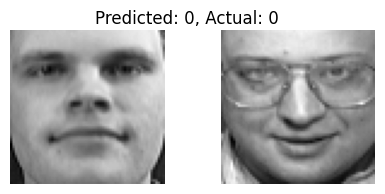

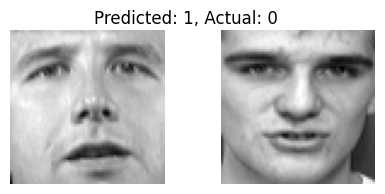

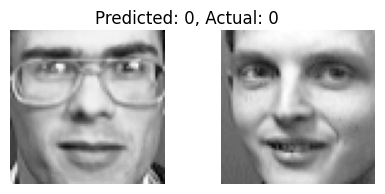

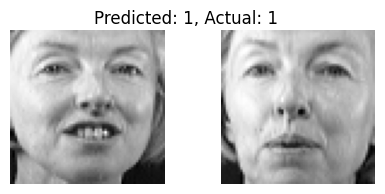

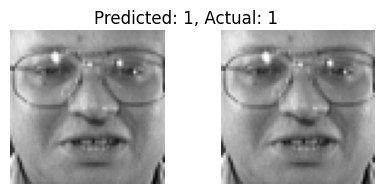

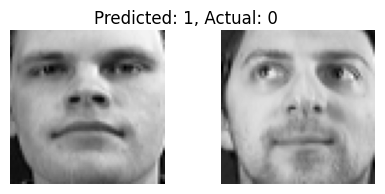

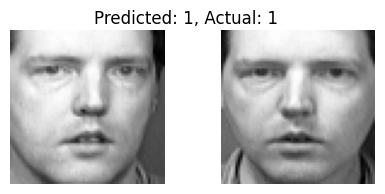

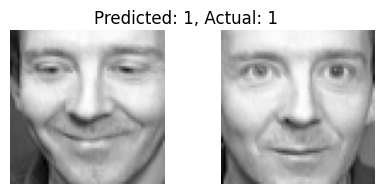

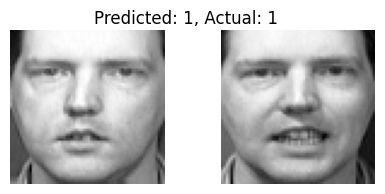

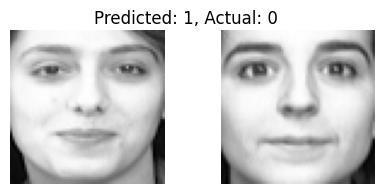

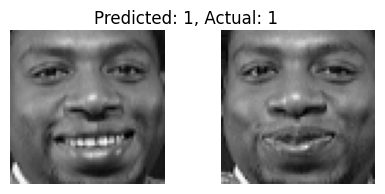

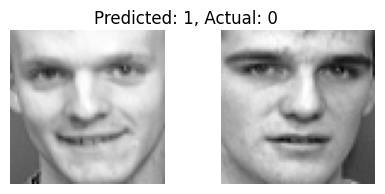

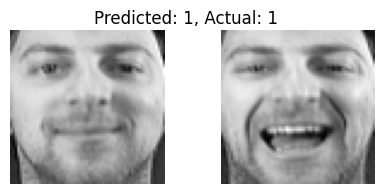

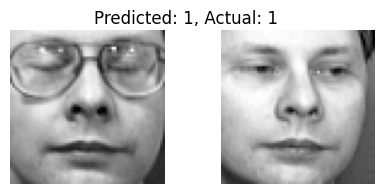

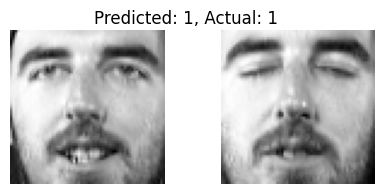

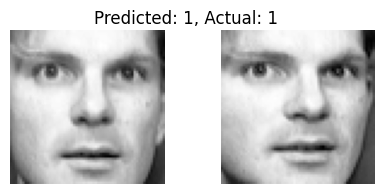

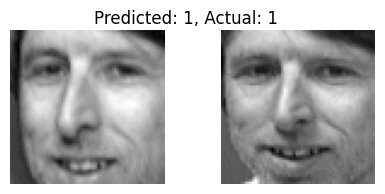

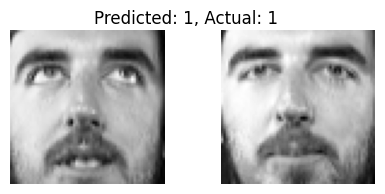

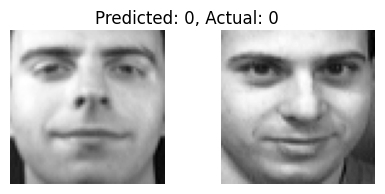

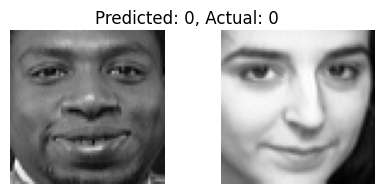

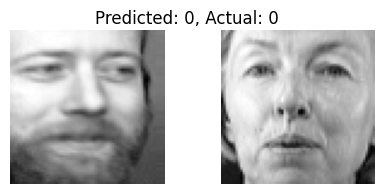

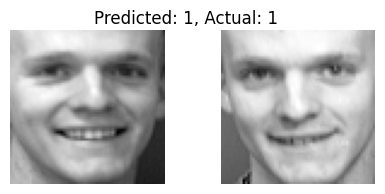

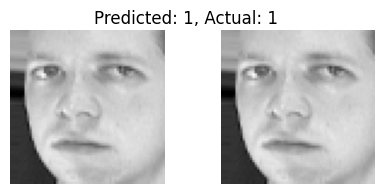

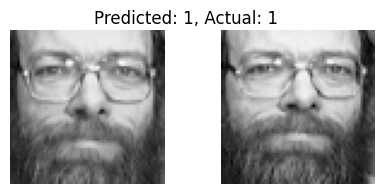

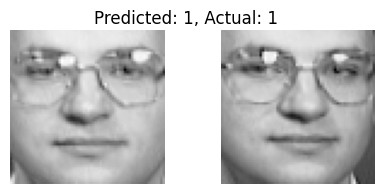

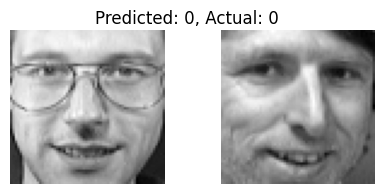

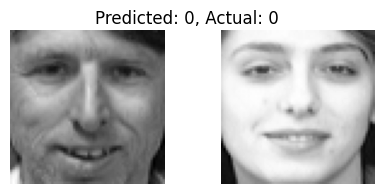

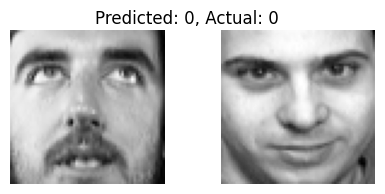

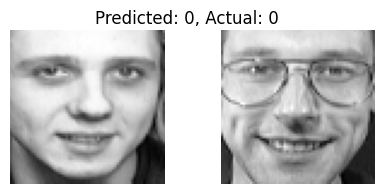

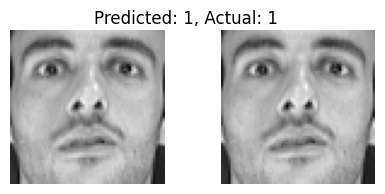

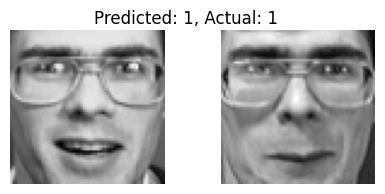

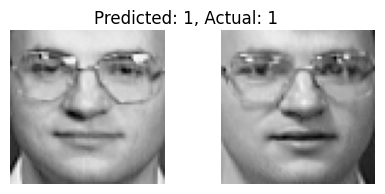

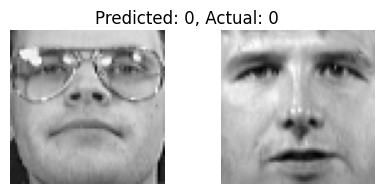

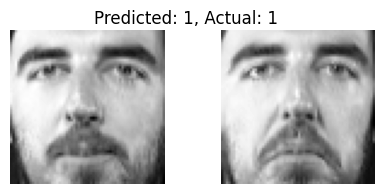

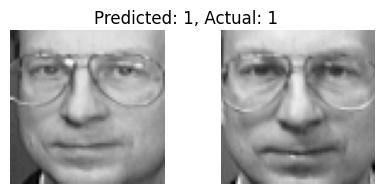

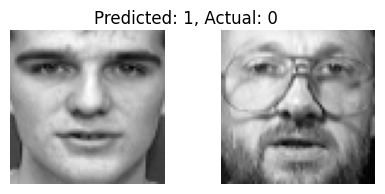

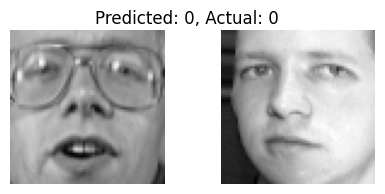

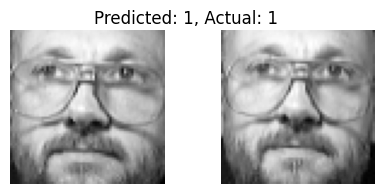

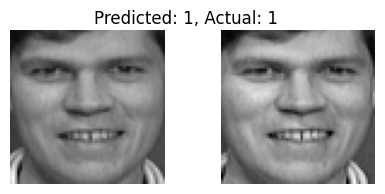

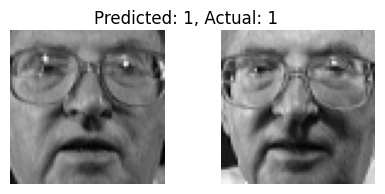

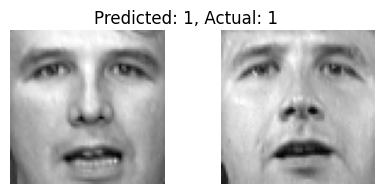

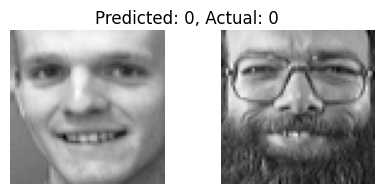

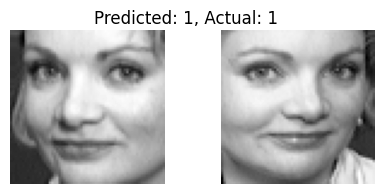

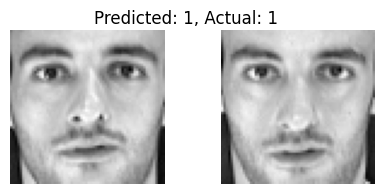

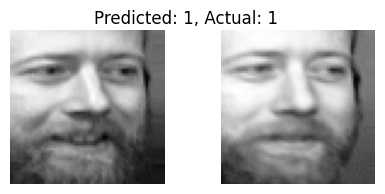

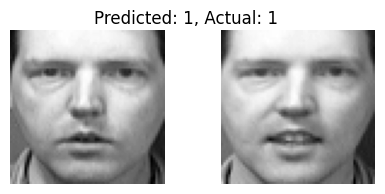

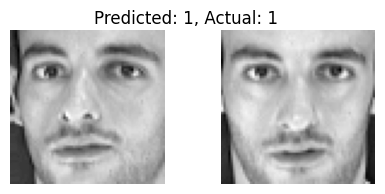

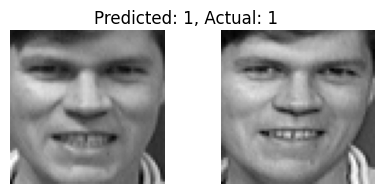

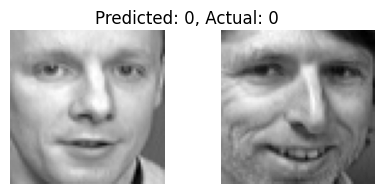

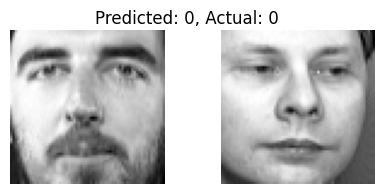

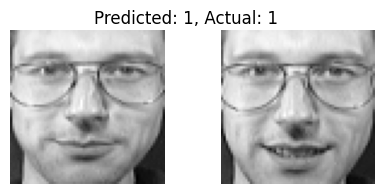

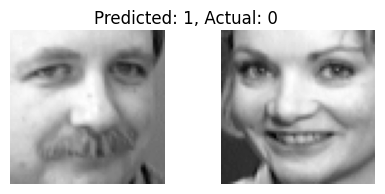

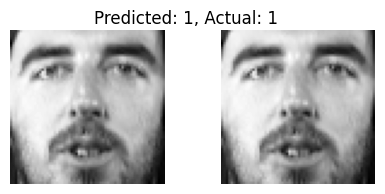

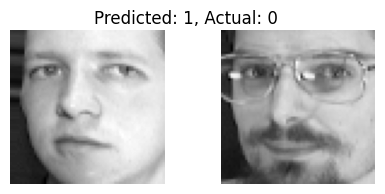

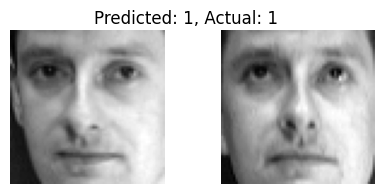

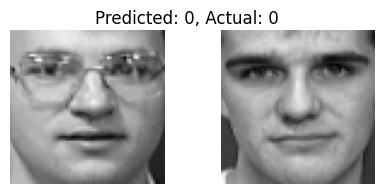

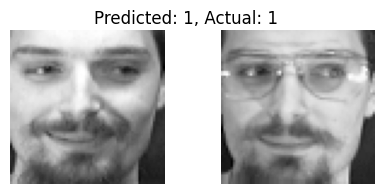

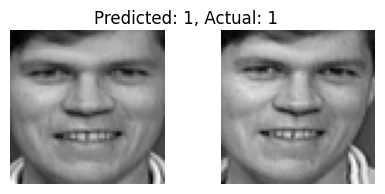

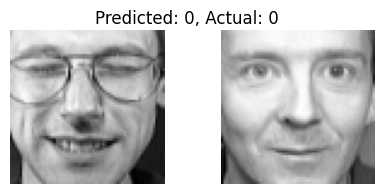

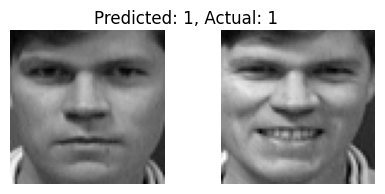

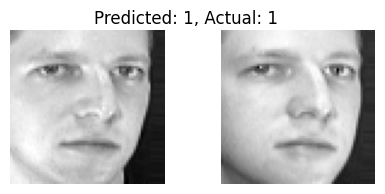

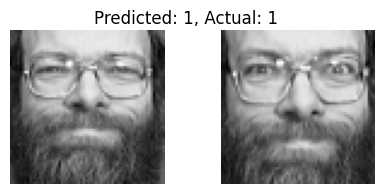

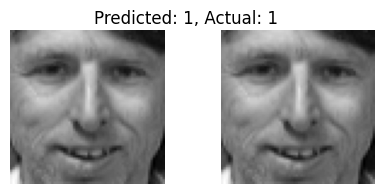

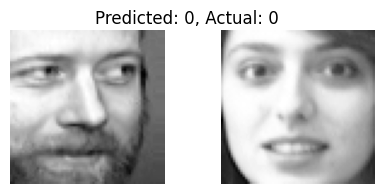

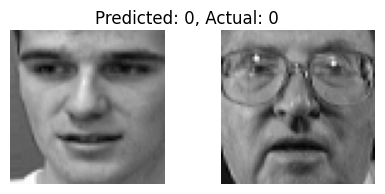

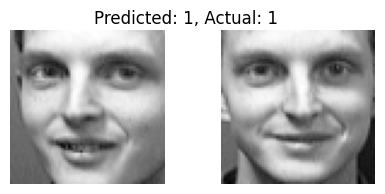

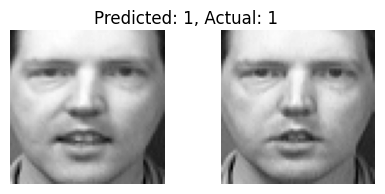

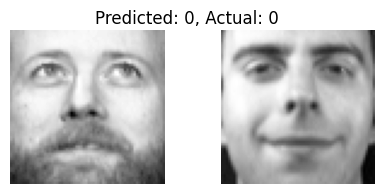

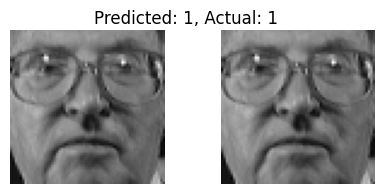

In [28]:
for index, pair in enumerate(test_images):
    show_images_and_predictions(pair, final_predictions[index], test_labels[index])

In [29]:
print('Length of training data:',len(train_images))
print('Length of testing data:',len(test_images))

Length of training data: 640
Length of testing data: 160
